In [1]:
import numpy as np
import pandas as pd

import math
import os

from sklearn.preprocessing import LabelEncoder, OneHotEncoder

%matplotlib inline
import matplotlib.pyplot as plt

os.chdir(r'...')

pd.options.mode.chained_assignment = None  # default='warn'

from tqdm import tnrange, tqdm_notebook

import os
import folium

from folium.plugins import HeatMap
import seaborn as sns; sns.set(style="white", color_codes=True)

RADIUS = 0.02

In [2]:
# Честное вычисление расстояния по координатам точек
# http://stackoverflow.com/questions/4913349/haversine-formula-in-python-bearing-and-distance-between-two-gps-points
def haversine(lat1, lon1, lat2, lon2):
    lon1, lat1, lon2, lat2 = list(map(math.radians, [lon1, lat1, lon2, lat2]))
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = math.sin(dlat / 2) ** 2 + math.cos(lat1) * math.cos(lat2) * math.sin(dlon / 2) ** 2
    c = 2 * math.asin(math.sqrt(a)) 
    r = 6371000 # Radius of earth in meters
    return c * r

In [3]:
# Честное вычисление работает очень долго, потому что в нем много тригонометрических функций
# Напишем более быструю функцию для нахождения маленьких расстояний (в этом случае поверхность Земли можно
# рассматривать как плоскость)

# длина в метрах одной сотой градуса по широте
LAT_001_DIST = haversine(0, 0, 0.01, 0)
# длина в метрах одной сотой градуса по долготе для каждой широты с шагом 0.01
LON_001_DIST = [haversine(i / 100.0, 0, i / 100.0, 0.01) for i in range(7500)]

def haversine_fast_sq(lat1, lon1, lat2, lon2):
    y = (lat1 - lat2) * LAT_001_DIST * 100
    key = int(100.0 * lat1)
    x = (lon1 - lon2) * LON_001_DIST[key] * 100
    return x * x + y * y

def haversine_fast(lat1, lon1, lat2, lon2):
    return math.sqrt(haversine_fast_sq(lat1, lon1, lat2, lon2))

# Переводит latlon координаты в x, y относительно origin
# Предполагается, что latlons находятся в первой четверти относительно origin и расстояния не очень
# большие, то есть поверхность можно рассматривать как плоскость 
def latlon_to_xy(latlons, origin):
    olat, olon = origin
    return [(haversine_fast(lat, lon, lat, olon), haversine_fast(lat, lon, olat, lon)) for lat, lon in latlons]

# Переводит x, y координаты в latlon относительно origin
def xy_to_latlon(xy, origin):
    olat, olon = origin
    lon = olon + xy[0] / (LON_001_DIST[int(100.0 * olat)] * 100)
    lat = olat + xy[1] / (LAT_001_DIST * 100)
    return lat, lon

In [4]:
train_results_class_work = pd.read_csv('2018_03_16_work_xgb_biclass_train.csv')
train_results_regres_work = pd.read_csv('2018_03_19_work_xgb_regression_train.csv')
train_results_class_home = pd.read_csv('2018_03_16_home_xgb_biclass_train.csv')
train_results_regres_home = pd.read_csv('2018_03_19_home_xgb_regression_train.csv')

#nearby_work_prob = pd.read_csv('2018_03_14_nearby_work_prob.csv', names=['work_prob'])
#sub_results_class_work['work_prob'] = nearby_work_prob

#nearby_home_prob = pd.read_csv('2018_03_14_nearby_home_prob.csv', names=['home_prob'])
#sub_results_class_home['home_prob'] = nearby_home_prob

train_results_class_work = train_results_class_work[train_results_class_work.columns[1:]]
train_results_regres_work = train_results_regres_work[train_results_regres_work.columns[1:]]
train_results_class_home = train_results_class_home[train_results_class_home.columns[1:]]
train_results_regres_home = train_results_regres_home[train_results_regres_home.columns[1:]]

train_results_class_home.rename(columns={'0':'h1'}, inplace=True)
train_results_class_work.rename(columns={'0':'w1'}, inplace=True)
train_results_regres_work.rename(columns={'0':'work_dist'}, inplace=True)
train_results_regres_home.rename(columns={'0':'home_dist'}, inplace=True)

print(len(train_results_regres_home), len(train_results_regres_work), 
      len(train_results_class_home), len(train_results_class_work))

#consolidated = pd.concat([sub_results_class_work, sub_results_class_home['h1']], axis=1)

705366 364532 705366 364532


In [5]:
train_home = pd.read_csv(r'...\data\\
train and test for modeling\2018_03_20_home_regression_train.csv')

In [6]:
train_results_class_home['neighb_count'] = train_home['neighb_count']

In [7]:
"""берем медиану расстояния"""
distance_with_key_work = train_results_regres_work.groupby(
    ['customer_id', 'address_lat', 'address_lon'])['work_dist'].median().reset_index()
distance_with_key_home = train_results_regres_home.groupby(
    ['customer_id', 'address_lat', 'address_lon'])['home_dist'].median().reset_index()
len(distance_with_key_work), len(distance_with_key_home)

(121491, 231142)

In [8]:
"""создаем ключ latlon"""
distance_with_key_work['gps'] = (distance_with_key_work['address_lat'].astype(str) + ', ' 
                                 + distance_with_key_work['address_lon'].astype(str))
distance_with_key_home['gps'] = (distance_with_key_home['address_lat'].astype(str) + ', ' 
                                 + distance_with_key_home['address_lon'].astype(str))
train_results_class_work['gps'] = (train_results_class_work['address_lat'].astype(str) + ', ' 
                                   + train_results_class_work['address_lon'].astype(str))
train_results_class_home['gps'] = (train_results_class_home['address_lat'].astype(str) + ', ' 
                                   + train_results_class_home['address_lon'].astype(str))

In [9]:
train_results_class_work = pd.merge(train_results_class_work, distance_with_key_work[['customer_id', 'gps', 'work_dist']], 
                             on=['customer_id', 'gps'], how='left')
train_results_class_home = pd.merge(train_results_class_home, distance_with_key_home[['customer_id', 'gps', 'home_dist']], 
                             on=['customer_id', 'gps'], how='left')

In [ ]:
#consolidated df - skip this step

In [10]:
consolidated = pd.merge(train_results_class_work, 
                        train_results_class_home[['customer_id', 'gps', 'h1', 'home_dist', 'neighb_count']], 
         on=['customer_id','gps'], how='left')

In [344]:
consolidated = consolidated[consolidated.h1.isnull()==0]

In [355]:
regular = 0

consolidated['w2'] = consolidated['w1'] - (consolidated['neighb_count'] == 1).astype(int) * regular
consolidated['h2'] = consolidated['h1'] - (consolidated['neighb_count'] == 1).astype(int) * regular

In [236]:
consolidated['w2'] = ((consolidated['w1'] / (consolidated['w1'] + consolidated['h1'])) * 0.2 + consolidated['w1'] * 0.8) 
consolidated['h2'] = ((consolidated['h1'] / (consolidated['w1'] + consolidated['h1'])) * 0.2 + consolidated['h1'] * 0.8) 

In [330]:
consolidated['w2'] = 1 - ((np.log1p(consolidated['work_dist']) / 
                           (np.log1p(consolidated['work_dist']) + np.log1p(consolidated['home_dist']))))
consolidated['h2'] = (np.log1p(consolidated['work_dist']) / 
                      (np.log1p(consolidated['work_dist']) + np.log1p(consolidated['home_dist'])))

In [322]:
consolidated['w2'] = (consolidated['w2'] + consolidated['w1']) / 2
consolidated['h2'] = (consolidated['h2'] + consolidated['h1']) / 2

In [366]:
consolidated['w2'] = ((1 / consolidated['work_dist']**2)  * consolidated['w1'])
consolidated['h2'] = ((1 / consolidated['home_dist']**2)  * consolidated['h1'])

In [345]:
consolidated.head()

,w1,y,ttl_count,address_lat,address_lon,customer_id,clusters,home_add_lat,home_add_lon,work_add_lat,work_add_lon,gps,work_dist_x,prob_dist,work_dist_y,work_dist,h1,home_dist,neighb_count
0,0.9947,1.0,38.0,59.844074,30.179153,0dc0137d280a2a82d2dc89282450ff1b,0,59.851,30.232,59.847,30.177,"59.8440742493, 30.1791534424",340.641174,0.000009,340.641174,340.641174,0.018225,2843.996582,28.0
1,0.9947,1.0,38.0,59.844074,30.179153,0dc0137d280a2a82d2dc89282450ff1b,0,59.851,30.232,59.847,30.177,"59.8440742493, 30.1791534424",340.641174,0.000009,340.641174,340.641174,0.016951,2843.996582,28.0
2,0.9947,1.0,38.0,59.844074,30.179153,0dc0137d280a2a82d2dc89282450ff1b,0,59.851,30.232,59.847,30.177,"59.8440742493, 30.1791534424",340.641174,0.000009,340.641174,340.641174,0.017793,2843.996582,28.0
3,0.9947,1.0,38.0,59.844074,30.179153,0dc0137d280a2a82d2dc89282450ff1b,0,59.851,30.232,59.847,30.177,"59.8440742493, 30.1791534424",340.641174,0.000009,340.641174,340.641174,0.020062,2843.996582,28.0
4,0.9947,1.0,38.0,59.844074,30.179153,0dc0137d280a2a82d2dc89282450ff1b,0,59.851,30.232,59.847,30.177,"59.8440742493, 30.1791534424",340.641174,0.000009,340.641174,340.641174,0.018079,2843.996582,28.0


In [329]:
(consolidated['w1'] + consolidated['h1']).max()

1.9998596906661987

In [12]:
"""BEST SCORE"""
train_results_class_work['prob_dist'] = ((1 / train_results_class_work['work_dist']**2)  * train_results_class_work['w1'])
train_results_class_home['prob_dist'] = ((1 / train_results_class_home['home_dist']**2)  * train_results_class_home['h1'])

In [63]:
#train_results_class_work['prob_dist'] = ((2000 >= train_results_class_work['work_dist'])
#                                         * train_results_class_work['work_dist'] / 20000  + train_results_class_work['w1'])
#train_results_class_home['prob_dist'] = ((2000 >= train_results_class_home['home_dist'])
#                                         * train_results_class_home['home_dist'] / 20000  + train_results_class_home['h1'])

In [92]:
#train_results_class_work['prob_dist'] = (2000 / train_results_class_work['work_dist']) * 0.2 + train_results_class_work['w1']
#train_results_class_home['prob_dist'] = (2000 / train_results_class_home['home_dist']) * 0.2 + train_results_class_home['h1']

In [100]:
#train_results_class_work['prob_dist'] = train_results_class_work['w1']
#train_results_class_home['prob_dist'] = train_results_class_home['h1']

In [115]:
#train_results_class_work['prob_dist'] = (1 / train_results_class_work['work_dist'])
#train_results_class_home['prob_dist'] = (1 / train_results_class_home['home_dist'])

In [15]:
work_answer_train = train_results_class_work[train_results_class_work.groupby(
['customer_id'])['prob_dist'].transform(max) == train_results_class_work['prob_dist'] ].drop_duplicates(
    'customer_id')[['customer_id','address_lat','address_lon', 'work_add_lat', 'work_add_lon']]

home_answer_train = train_results_class_home[train_results_class_home.groupby(
['customer_id'])['prob_dist'].transform(max) == train_results_class_home['prob_dist'] ].drop_duplicates(
    'customer_id')[['customer_id','address_lat','address_lon', 'home_add_lat', 'home_add_lon']]

In [ ]:
#work_answer_train = consolidated[consolidated.groupby(
#['customer_id'])['w2'].transform(max) == consolidated['w2'] ].drop_duplicates(
#    'customer_id')[['customer_id','address_lat','address_lon', 'work_add_lat', 'work_add_lon']]

#home_answer_train = consolidated[consolidated.groupby(
#['customer_id'])['h2'].transform(max) == consolidated['h2'] ].drop_duplicates(
#    'customer_id')[['customer_id','address_lat','address_lon', 'home_add_lat', 'home_add_lon']]

In [73]:
len(work_answer_train), len(home_answer_train)

(3732, 7649)

In [368]:
"""WORK"""
(np.where((np.sqrt(((work_answer_train.address_lat - work_answer_train.work_add_lat) ** 2) + 
        ((work_answer_train.address_lon - work_answer_train.work_add_lon) ** 2)) <= RADIUS), .5, 0).sum()
 / len(work_answer_train))

0.35619754680438992

In [369]:
"""HOME"""
(np.where((np.sqrt(((home_answer_train.address_lat - home_answer_train.home_add_lat) ** 2) + 
        ((home_answer_train.address_lon - home_answer_train.home_add_lon) ** 2)) <= RADIUS), .5, 0).sum()
 / len(home_answer_train))

0.43237572627501614

In [391]:
home_answer_train[(np.where((np.sqrt(((home_answer_train.address_lat - home_answer_train.home_add_lat) ** 2) + 
        ((home_answer_train.address_lon - home_answer_train.home_add_lon) ** 2)) <= RADIUS), .5, 0) == 0) == 1]['customer_id'][10:30]

168594    0d1c8fffd6e35a942e89ba2264837573
177575    785f11d626ac8e6b21c512e5e00bef95
216263    c21999a5ad31fa3c1731e14580d80d04
219741    4bec4641fa65c9e6e8a72432dcf6e6c4
228397    a3751c8c4c5a381a39b7a87ddf391e0a
264980    31d2c43181588b84811159985e74c18a
266783    4263d63bb06695064038e693ae6761a2
283334    741269285416cf8f5cbadc5a4fa62b3d
295821    b595b93570eb333b73f8d93ff7ace6cd
296429    bd92aa5b0ef60b6b35dedd79710ead99
308252    35f2ab84350fa8b620b9c605360cf0c4
328661    95a5f1fdcb9c27bdb6279cbb46598c93
333941    afe1e6acfdbdfa823f9104fdd0065dd0
335286    b4e4d954511acc1c7e7710c38975248e
338617    0ac47205e183896b0164a6692604142a
387002    af8e3c224509de92b734eb929e8466be
390133    14d0f64dd51b3bab4b1fcd58092ea509
405345    9c3674d189e58317c425e3bd755d811c
417008    4a3cf489f6505ab557de7036aa21ef18
417758    ef2ac658bde43c9ea81df37638d5a7c3
Name: customer_id, dtype: object

In [16]:
work_answer_train[work_answer_train.customer_id == '785f11d626ac8e6b21c512e5e00bef95']

,customer_id,address_lat,address_lon,work_add_lat,work_add_lon
8879,785f11d626ac8e6b21c512e5e00bef95,55.653,37.620712,55.746,37.595


In [17]:
idn = '0ac47205e183896b0164a6692604142a'

m = folium.Map([55., 37.], tiles='stamentoner', zoom_start=6)

HeatMap(consolidated[consolidated.customer_id == idn]
        [['address_lat', 'address_lon']].values.tolist()).add_to(m)

folium.Marker([work_answer_train[work_answer_train.customer_id == idn]['address_lat'].mean(), 
               work_answer_train[work_answer_train.customer_id == idn]['address_lon'].mean()], 
              popup='work', icon=folium.Icon(color='green')).add_to(m)
folium.Marker([work_answer_train[work_answer_train.customer_id == idn]['work_add_lat'].mean(), 
               work_answer_train[work_answer_train.customer_id == idn]['work_add_lon'].mean()], 
              popup='work', icon=folium.Icon(color='red')).add_to(m)

folium.Marker([home_answer_train[home_answer_train.customer_id == idn]['address_lat'].mean(), 
               home_answer_train[home_answer_train.customer_id == idn]['address_lon'].mean()], 
              popup='home', icon=folium.Icon(color='green')).add_to(m)
folium.Marker([home_answer_train[home_answer_train.customer_id == idn]['home_add_lat'].mean(), 
               home_answer_train[home_answer_train.customer_id == idn]['home_add_lon'].mean()], 
              popup='home', icon=folium.Icon(color='red')).add_to(m)

m

In [155]:
"""вычисляем топ по каждому ID"""
def top(df, n=3, column='y_pred'):
    return df.sort_values(by=column)[-n:]

"""вычислям взвешенное среднее значение"""
def weighted_average(df,data_col,weight_col,by_col):
    df['_data_times_weight'] = df[data_col]*df[weight_col]
    df['_weight_where_notnull'] = df[weight_col]*pd.notnull(df[data_col])
    g = df.groupby(by_col)
    result = g['_data_times_weight'].sum() / g['_weight_where_notnull'].sum()
    del df['_data_times_weight'], df['_weight_where_notnull']
    return result

In [156]:
train_results_class_work['gps'] = (train_results_class_work['address_lat'].astype(str) + ', '
                                   + train_results_class_work['address_lon'].astype(str))
train_results_class_home['gps'] = (train_results_class_home['address_lat'].astype(str) + ', '
                                   + train_results_class_home['address_lon'].astype(str))

In [189]:
%%time
work_results_dic_median_prob = {}
#work_results_dic_max = {}

for q in [1,2,3,4,5,7,9,11]:
    
    """по уникальным координатам ищем максимальные значения"""
    un_gps_only = train_results_class_work.groupby(['customer_id', 'gps']).agg({'w1': [np.size, np.median]}).reset_index()
    un_gps_only.columns = un_gps_only.columns.droplevel(1)
    un_gps_only.columns = ['customer_id', 'gps', 'count', 'mean']

    """находим топ-n по вер-ти"""
    un_gps_only = un_gps_only.groupby('customer_id').apply(top, n=q, column='mean')
    un_gps_only.reset_index(drop=True, inplace=True)
    un_gps_only['address_lat'] = un_gps_only['gps'].map(lambda x: str(x).split(',')[0]).apply(float)
    un_gps_only['address_lon'] = un_gps_only['gps'].map(lambda x: str(x).split(',')[1]).apply(float)


    un_gps_only['max_prob'] = un_gps_only.groupby(['customer_id'])['mean'].transform(max)
    max_prob_key = pd.DataFrame(un_gps_only.groupby(['customer_id'])['mean'].max()).reset_index()
    max_prob_key = pd.merge(max_prob_key, un_gps_only[['customer_id', 'mean', 'address_lat', 'address_lon']], 
             on=['customer_id', 'mean'], how='left')
    un_gps_only = pd.merge(un_gps_only, max_prob_key[['customer_id', 'address_lat', 'address_lon']],
                           on='customer_id', how='left')

    for r in [0.02, 0.025, 0.03, 0.035, 0.04, 0.045, 0.05, 0.055, 0.06, 0.065, 0.07, 0.075, 0.08, 0.085, 0.09]:
        
        proximity_radius = r
        un_gps_only['is_close'] = (un_gps_only['address_lat_x'].between(un_gps_only['address_lat_y'] - proximity_radius, 
                                              un_gps_only['address_lat_y'] + proximity_radius, inclusive=True) &
         un_gps_only['address_lon_x'].between(un_gps_only['address_lon_y'] - proximity_radius, 
                                              un_gps_only['address_lon_y'] + proximity_radius, inclusive=True)).astype(int)


        un_gps_only_nearest_points = un_gps_only[un_gps_only.is_close == 1]

        work_lat_answer = pd.DataFrame(weighted_average(un_gps_only_nearest_points, data_col='address_lat_x', 
                                                        weight_col='mean', by_col='customer_id')).reset_index()
        work_lon_answer = pd.DataFrame(weighted_average(un_gps_only_nearest_points, data_col='address_lon_x', 
                                                        weight_col='mean', by_col='customer_id')).reset_index()
        work_answer = pd.merge(work_lat_answer, work_lon_answer, on='customer_id', how='left')

        work_answer.columns = ['customer_id', 'address_lat', 'address_lon']
        work_answer_train.drop(['address_lat', 'address_lon'], axis=1, inplace=True)
        work_answer_train = pd.merge(work_answer_train, work_answer, on='customer_id', how='left')

        work_results_dic_median_prob[q, r] = (np.where((
            np.sqrt(((work_answer_train.address_lat - work_answer_train.work_add_lat) ** 2) 
                    + ((work_answer_train.address_lon - work_answer_train.work_add_lon) ** 2)) <= RADIUS), 0.5, 0).sum() 
                                         / len(work_answer_train))

Wall time: 1min 16s


In [187]:
weighted_average(un_gps_only_nearest_points, data_col='address_lat_x', 
                                                        weight_col='mean', by_col='customer_id').reset_index()

,customer_id,0
0,0001f322716470bf9bfc1708f06f00fc,44.716842
1,0007297d86e14bd68bd87b1dbdefe302,55.799905
2,000b709c6c6fb1e8efcfd95e57c2a9de,54.994608
3,0027a7618d97cc9fbda55fac457eaeb7,55.746592
4,002b9f6e118c54f1292e03d1a04d516e,55.802018
5,0031915eb230f772681fb5dc5a8d1c31,55.776548
6,003360bff9882ca4a4f93394dd984822,59.213757
7,0037f3de3d890df1022cc760a1dfd9d6,55.686178
8,003fa58414cc55531fcc38423bea8f8e,55.763176
9,0046c2952fb808aa11f74abce5abe097,54.671926


In [188]:
un_gps_only_nearest_points

,customer_id,gps,count,mean,address_lat_x,address_lon_x,max_prob,address_lat_y,address_lon_y,is_close
0,0001f322716470bf9bfc1708f06f00fc,"44.7377204895, 37.793006897",3.0,1.370705e-09,44.737720,37.793007,5.816093e-07,44.713001,37.777000,1
1,0001f322716470bf9bfc1708f06f00fc,"44.7239990234, 37.8120002747",1.0,1.418683e-09,44.723999,37.812000,5.816093e-07,44.713001,37.777000,1
2,0001f322716470bf9bfc1708f06f00fc,"44.7319984436, 37.8149986267",1.0,1.561652e-09,44.731998,37.814999,5.816093e-07,44.713001,37.777000,1
3,0001f322716470bf9bfc1708f06f00fc,"44.7260017395, 37.8120002747",1.0,1.811778e-09,44.726002,37.812000,5.816093e-07,44.713001,37.777000,1
4,0001f322716470bf9bfc1708f06f00fc,"44.7455368042, 37.7262763977",2.0,2.272952e-09,44.745537,37.726276,5.816093e-07,44.713001,37.777000,1
5,0001f322716470bf9bfc1708f06f00fc,"44.7299995422, 37.8190002441",1.0,2.402163e-09,44.730000,37.819000,5.816093e-07,44.713001,37.777000,1
6,0001f322716470bf9bfc1708f06f00fc,"44.726726532, 37.7558631897",1.0,6.588235e-08,44.726727,37.755863,5.816093e-07,44.713001,37.777000,1
7,0001f322716470bf9bfc1708f06f00fc,"44.7256851196, 37.7627334595",1.0,1.297524e-07,44.725685,37.762733,5.816093e-07,44.713001,37.777000,1
8,0001f322716470bf9bfc1708f06f00fc,"44.7210006714, 37.7659988403",1.0,1.542050e-07,44.721001,37.765999,5.816093e-07,44.713001,37.777000,1
9,0001f322716470bf9bfc1708f06f00fc,"44.7159996033, 37.7770004272",1.0,4.541670e-07,44.716000,37.777000,5.816093e-07,44.713001,37.777000,1


In [177]:
max(work_results_dic_median, key=work_results_dic_median.get)

(1, 0.02)

In [191]:
work_results_dic_median_prob

{(1, 0.02): 0.30359056806002144,
 (1, 0.025): 0.30359056806002144,
 (1, 0.03): 0.30359056806002144,
 (1, 0.035): 0.30359056806002144,
 (1, 0.04): 0.30359056806002144,
 (1, 0.045): 0.30359056806002144,
 (1, 0.05): 0.30359056806002144,
 (1, 0.055): 0.30359056806002144,
 (1, 0.06): 0.30359056806002144,
 (1, 0.065): 0.30359056806002144,
 (1, 0.07): 0.30359056806002144,
 (1, 0.075): 0.30359056806002144,
 (1, 0.08): 0.30359056806002144,
 (1, 0.085): 0.30359056806002144,
 (1, 0.09): 0.30359056806002144,
 (2, 0.02): 0.3088156484458735,
 (2, 0.025): 0.31162915326902463,
 (2, 0.03): 0.31390675241157556,
 (2, 0.035): 0.31524651661307612,
 (2, 0.04): 0.3163183279742765,
 (2, 0.045): 0.31712218649517687,
 (2, 0.05): 0.317524115755627,
 (2, 0.055): 0.31806002143622725,
 (2, 0.06): 0.31806002143622725,
 (2, 0.065): 0.31806002143622725,
 (2, 0.07): 0.31806002143622725,
 (2, 0.075): 0.31806002143622725,
 (2, 0.08): 0.31819399785637725,
 (2, 0.085): 0.31819399785637725,
 (2, 0.09): 0.31806002143622725,


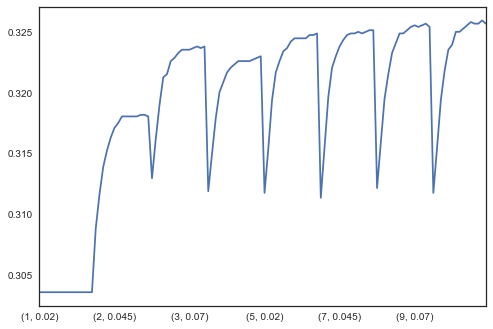

In [190]:
pd.Series(work_results_dic_median_prob).plot()

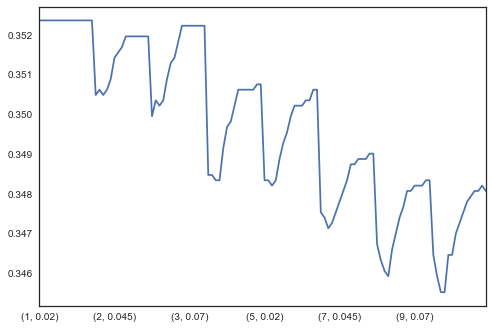

In [179]:
pd.Series(work_results_dic_max).plot()

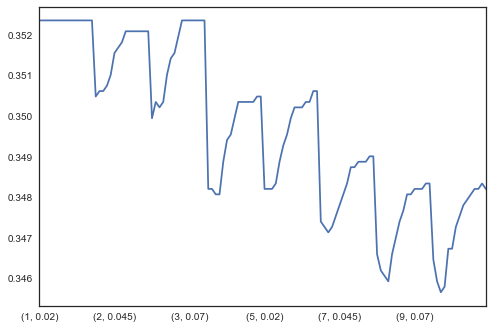

In [166]:
pd.Series(work_results_dic_median).plot()

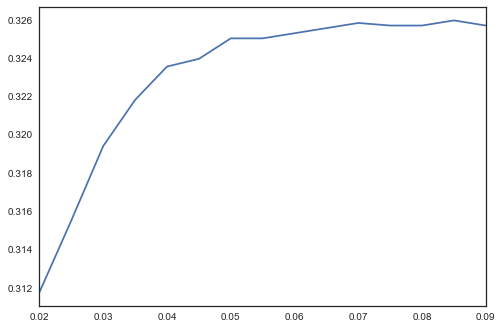

In [88]:
pd.Series(radius_dic).plot();

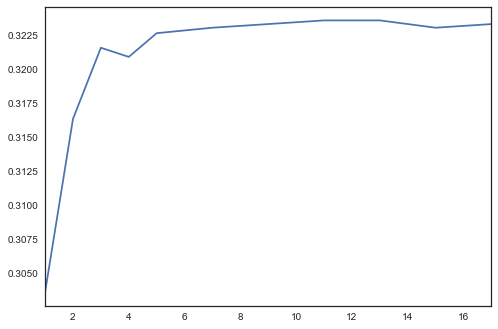

In [89]:
pd.Series(results_dic).plot();

In [94]:
radius_dic.keys()

dict_keys([0.02, 0.025, 0.03, 0.035, 0.04, 0.045, 0.05, 0.055, 0.06, 0.065, 0.07, 0.075, 0.08, 0.085, 0.09])

In [184]:
%%time
home_results_dic_median = {}
#home_results_dic_max = {}

for q in [1,2,3,4,5,7,9,11]:
    
    """по уникальным координатам ищем максимальные значения"""
    un_gps_only = train_results_class_home.groupby(['customer_id', 'gps']).agg({'prob_dist': [np.size, np.median]}).reset_index()
    un_gps_only.columns = un_gps_only.columns.droplevel(1)
    un_gps_only.columns = ['customer_id', 'gps', 'count', 'mean']

    """находим топ-n по вер-ти"""
    un_gps_only = un_gps_only.groupby('customer_id').apply(top, n=q, column='mean')
    un_gps_only.reset_index(drop=True, inplace=True)
    un_gps_only['address_lat'] = un_gps_only['gps'].map(lambda x: str(x).split(',')[0]).apply(float)
    un_gps_only['address_lon'] = un_gps_only['gps'].map(lambda x: str(x).split(',')[1]).apply(float)


    un_gps_only['max_prob'] = un_gps_only.groupby(['customer_id'])['mean'].transform(max)
    max_prob_key = pd.DataFrame(un_gps_only.groupby(['customer_id'])['mean'].max()).reset_index()
    max_prob_key = pd.merge(max_prob_key, un_gps_only[['customer_id', 'mean', 'address_lat', 'address_lon']], 
             on=['customer_id', 'mean'], how='left')
    un_gps_only = pd.merge(un_gps_only, max_prob_key[['customer_id', 'address_lat', 'address_lon']],
                           on='customer_id', how='left')

    for r in [0.02, 0.025, 0.03, 0.035, 0.04, 0.045, 0.05, 0.055, 0.06, 0.065, 0.07, 0.075, 0.08, 0.085, 0.09]:
        
        proximity_radius = r
        un_gps_only['is_close'] = (un_gps_only['address_lat_x'].between(un_gps_only['address_lat_y'] - proximity_radius, 
                                              un_gps_only['address_lat_y'] + proximity_radius, inclusive=True) &
         un_gps_only['address_lon_x'].between(un_gps_only['address_lon_y'] - proximity_radius, 
                                              un_gps_only['address_lon_y'] + proximity_radius, inclusive=True)).astype(int)


        un_gps_only_nearest_points = un_gps_only[un_gps_only.is_close == 1]

        home_lat_answer = pd.DataFrame(weighted_average(un_gps_only_nearest_points, data_col='address_lat_x', 
                                                        weight_col='mean', by_col='customer_id')).reset_index()
        home_lon_answer = pd.DataFrame(weighted_average(un_gps_only_nearest_points, data_col='address_lon_x', 
                                                        weight_col='mean', by_col='customer_id')).reset_index()
        home_answer = pd.merge(home_lat_answer, home_lon_answer, on='customer_id', how='left')

        home_answer.columns = ['customer_id', 'address_lat', 'address_lon']
        home_answer_train.drop(['address_lat', 'address_lon'], axis=1, inplace=True)
        home_answer_train = pd.merge(home_answer_train, home_answer, on='customer_id', how='left')

        home_results_dic_median[q, r] = (np.where((
            np.sqrt(((home_answer_train.address_lat - home_answer_train.home_add_lat) ** 2) 
                    + ((home_answer_train.address_lon - home_answer_train.home_add_lon) ** 2)) <= RADIUS), 0.5, 0).sum() 
                                         / len(home_answer_train))

Wall time: 1min 28s


In [194]:
home_results_dic_median

{(1, 0.02): 0.42966400836710683,
 (1, 0.025): 0.42966400836710683,
 (1, 0.03): 0.42966400836710683,
 (1, 0.035): 0.42966400836710683,
 (1, 0.04): 0.42966400836710683,
 (1, 0.045): 0.42966400836710683,
 (1, 0.05): 0.42966400836710683,
 (1, 0.055): 0.42966400836710683,
 (1, 0.06): 0.42966400836710683,
 (1, 0.065): 0.42966400836710683,
 (1, 0.07): 0.42966400836710683,
 (1, 0.075): 0.42966400836710683,
 (1, 0.08): 0.42966400836710683,
 (1, 0.085): 0.42966400836710683,
 (1, 0.09): 0.42966400836710683,
 (2, 0.02): 0.42992548045496143,
 (2, 0.025): 0.4297947444110341,
 (2, 0.03): 0.42972937638907049,
 (2, 0.035): 0.42966400836710683,
 (2, 0.04): 0.42966400836710683,
 (2, 0.045): 0.42972937638907049,
 (2, 0.05): 0.42992548045496143,
 (2, 0.055): 0.43005621649888875,
 (2, 0.06): 0.43005621649888875,
 (2, 0.065): 0.43005621649888875,
 (2, 0.07): 0.43005621649888875,
 (2, 0.075): 0.43005621649888875,
 (2, 0.08): 0.43005621649888875,
 (2, 0.085): 0.43005621649888875,
 (2, 0.09): 0.4301215845208524

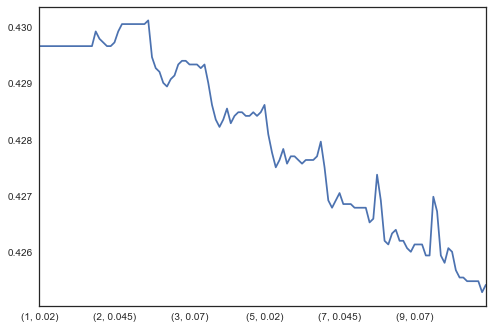

In [192]:
pd.Series(home_results_dic_median).plot();

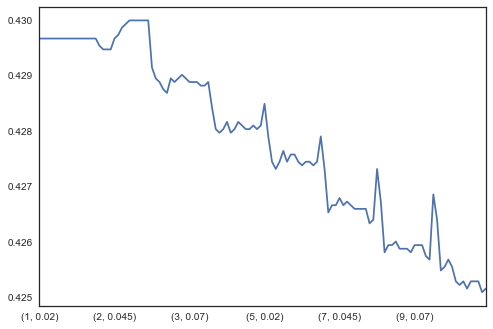

In [183]:
pd.Series(home_results_dic_max).plot();

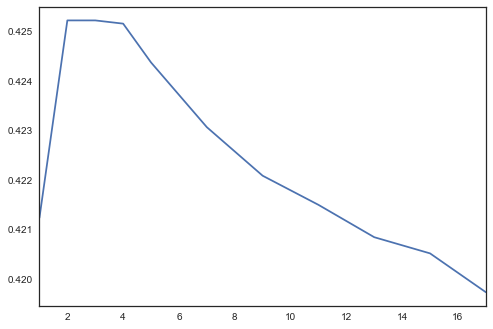

In [87]:
pd.Series(results_dic_home).plot();

In [62]:
"""берем медиану расстояния"""
distance_with_key_work = sub_results_regres_work.groupby(
    ['customer_id', 'address_lat', 'address_lon'])['work_dist'].median().reset_index()
distance_with_key_home = sub_results_regres_home.groupby(
    ['customer_id', 'address_lat', 'address_lon'])['home_dist'].median().reset_index()
len(distance_with_key_work), len(distance_with_key_home)

(298023, 298015)

In [63]:
"""создаем ключ latlon"""
distance_with_key_work['gps'] = (distance_with_key_work['address_lat'].astype(str) + ', ' 
                                 + distance_with_key_work['address_lon'].astype(str))
distance_with_key_home['gps'] = (distance_with_key_home['address_lat'].astype(str) + ', ' 
                                 + distance_with_key_home['address_lon'].astype(str))
consolidated['gps'] = consolidated['address_lat'].astype(str) + ', ' + consolidated['address_lon'].astype(str)

In [64]:
"""добавляем дистанцию"""
consolidated = pd.merge(consolidated, distance_with_key_work[['customer_id', 'gps', 'work_dist']], 
                             on=['customer_id', 'gps'], how='left')
consolidated = pd.merge(consolidated, distance_with_key_home[['customer_id', 'gps', 'home_dist']], 
                             on=['customer_id', 'gps'], how='left')
#consolidated.drop('y_pred', axis=1, inplace=True)
"""NaN можно выкинуть"""
consolidated.dropna(inplace=True)

In [64]:
"""выгружаем реальные координаты домов/работы"""
train_real_address = pd.read_excel(r'...\2018_03_13_train_real_address.xlsx')

In [119]:
"""offline подход (быстрый): https://github.com/thampiman/reverse-geocoder """
import reverse_geocoder as rg

latlon_subset = consolidated[['address_lat', 'address_lon']]
latlon_tuple = [tuple(x) for x in latlon_subset.values]
reverse_geo = rg.search(latlon_tuple)
reverse_geo_df = pd.DataFrame(reverse_geo)

consolidated['country'] = reverse_geo_df['cc'].values
consolidated['region'] = reverse_geo_df['admin1'].values
consolidated['place'] = reverse_geo_df['name'].values                            

latlon_subset = train_real_address[train_real_address['work_add_lat'].isnull()==0][['work_add_lat', 'work_add_lon']]
latlon_tuple = [tuple(x) for x in latlon_subset.values]
reverse_geo = rg.search(latlon_tuple)
reverse_geo_df = pd.DataFrame(reverse_geo)

train_real_address.loc[train_real_address[train_real_address['work_add_lat'].isnull()==0].index,
                       'w_country'] = reverse_geo_df['cc'].values
train_real_address.loc[train_real_address[train_real_address['work_add_lat'].isnull()==0].index,
                       'w_region'] = reverse_geo_df['admin1'].values
train_real_address.loc[train_real_address[train_real_address['work_add_lat'].isnull()==0].index,
                       'w_place'] = reverse_geo_df['name'].values

latlon_subset = train_real_address[['home_add_lat', 'home_add_lon']]
latlon_tuple = [tuple(x) for x in latlon_subset.values]
reverse_geo = rg.search(latlon_tuple)
reverse_geo_df = pd.DataFrame(reverse_geo)

train_real_address['h_country'] = reverse_geo_df['cc'].values
train_real_address['h_region'] = reverse_geo_df['admin1'].values
train_real_address['h_place'] = reverse_geo_df['name'].values  

In [74]:
(submission['_WORK_LAT_'].between(submission['_HOME_LAT_'] - RADIUS, 
                                      submission['_HOME_LAT_'] + RADIUS, inclusive=True) &
 (submission['_WORK_LON_'].between(submission['_HOME_LON_'] - RADIUS, 
                                      submission['_HOME_LON_'] + RADIUS, inclusive=True))).astype(int).sum()

5402

In [120]:
sub35['in'] = (sub35['_WORK_LAT_'].between(sub35['_HOME_LAT_'] - RADIUS, 
                                      sub35['_HOME_LAT_'] + RADIUS, inclusive=True) &
 (sub35['_WORK_LON_'].between(sub35['_HOME_LON_'] - RADIUS, 
                                      sub35['_HOME_LON_'] + RADIUS, inclusive=True))).astype(int)

In [123]:
sub35 = pd.merge(sub35, pd.DataFrame(consolidated.groupby('customer_id')['h1'].count()).reset_index(), 
                 left_on='_ID_', right_on='customer_id', how='left')

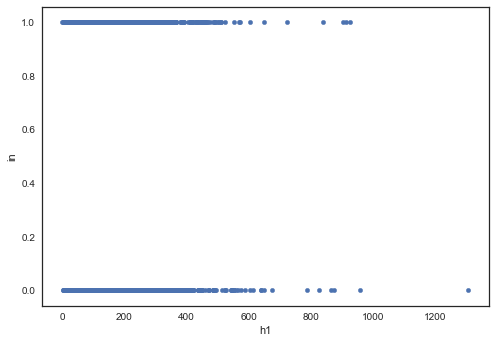

In [127]:
sub35.plot.scatter(y='in', x='h1')ж

In [56]:
sub38 = pd.read_csv(r'...\sub38.csv')
sub40 = pd.read_csv(r'...\sub40.csv')

In [76]:
"""доля пересечения работа / дом в сабе"""
(sub38['_WORK_LAT_'].between(sub38['_HOME_LAT_'] - RADIUS, 
                                      sub38['_HOME_LAT_'] + RADIUS, inclusive=True) &
 (sub38['_WORK_LON_'].between(sub38['_HOME_LON_'] - RADIUS, 
                                      sub38['_HOME_LON_'] + RADIUS, inclusive=True))).astype(int).sum() / 9997

0.54956486946083827

In [77]:
"""доля пересечения работа / дом в трейне"""
(train_real_address[
    train_real_address.work_add_lat.isnull()==0]['work_add_lat'].between(
    train_real_address[train_real_address.work_add_lat.isnull()==0]['home_add_lat'] - RADIUS,
    train_real_address[train_real_address.work_add_lat.isnull()==0]['home_add_lat'] + RADIUS, inclusive=True) & (
    train_real_address[train_real_address.work_add_lat.isnull()==0]['work_add_lon'].between(
        train_real_address[train_real_address.work_add_lat.isnull()==0]['work_add_lon'] - RADIUS, 
        train_real_address[train_real_address.work_add_lat.isnull()==0]['home_add_lon'] + RADIUS, 
        inclusive=True))).astype(int).sum() / len(train_real_address[train_real_address.work_add_lat.isnull()==0])

0.20395502132609539

In [123]:
latlon_subset = sub35[['_WORK_LAT_', '_WORK_LON_']]
latlon_tuple = [tuple(x) for x in latlon_subset.values]
reverse_geo = rg.search(latlon_tuple)
reverse_geo_df = pd.DataFrame(reverse_geo)

sub35['w_country'] = reverse_geo_df['cc'].values
sub35['w_region'] = reverse_geo_df['admin1'].values
sub35['w_place'] = reverse_geo_df['name'].values                              

latlon_subset = sub35[['_HOME_LAT_', '_HOME_LON_']]
latlon_tuple = [tuple(x) for x in latlon_subset.values]
reverse_geo = rg.search(latlon_tuple)
reverse_geo_df = pd.DataFrame(reverse_geo)

sub35['h_country'] = reverse_geo_df['cc'].values
sub35['h_region'] = reverse_geo_df['admin1'].values
sub35['h_place'] = reverse_geo_df['name'].values

In [133]:
((sub35[sub35.w_place == "Zamoskvorech'ye"]['w_place'] == sub35[sub35.w_place == "Zamoskvorech'ye"]['h_place']).sum() / 
(sub35[sub35.w_place == "Zamoskvorech'ye"]['w_place'] == sub35[sub35.w_place == "Zamoskvorech'ye"]['h_place']).count())

0.22866894197952217

In [134]:
((train_real_address[train_real_address.w_place == "Zamoskvorech'ye"]['w_place'] == 
  train_real_address[train_real_address.w_place == "Zamoskvorech'ye"]['h_place']).sum() / 
(train_real_address[train_real_address.w_place == "Zamoskvorech'ye"]['w_place'] == 
 train_real_address[train_real_address.w_place == "Zamoskvorech'ye"]['h_place']).count())

0.032967032967032968

In [63]:
consolidated.groupby('customer_id')['w0'].count().sort_values(ascending=False)[2800:2820]

customer_id
510af4ee2f937ea642d74fa506825090    113
2477378894819f88ffa5dc10146b902c    113
a43cdce7e3463eb8719607ff9f7571bd    113
f4fb8c79f10318566202bc9558964abf    113
530f596aa79efde2885f1d3abcea8292    113
a39b720b7a4795edc01fd6f052e2ccf3    113
d0c494ec5edbd9833aeb1bc39e4ce413    113
89555985aab3bbd4462ab36d6b9cd6b2    113
ac58df29f0759f9196f54941907cb3e5    113
07b1d7b7d7f8b488aa95ec991f5badcd    113
07ae8911763c78f68dc0da6cfa742b22    113
e75532906c913e3e0c82c6df06021045    113
a8e64ad69991a2bfc5f3c28e17dbbabd    113
9b61281e4cad5ab476733884a138d452    113
e6a315859a11a6108bcd695d03717861    113
3ce2cc35988aed3d2aff0d6459f6b033    113
b52ed9058580811d6d86909a09f68791    113
0fd1cbb537c03feb8ff11bdff0b8e28b    113
374e336c7dbea7be2d0b6bd4b0b92707    113
63b70f6c527c0e184301829a23e01ff0    113
Name: w0, dtype: int64

In [85]:
set(list(consolidated['customer_id'].unique())) - set(list(consolidated[consolidated.h1 > 0.6]['customer_id'].unique()))

{'5bff2736109861f59b8c9e00031534b0',
 '9cb829d0bd22c31ec4828fe9215bf73b',
 '91cccea3b88c87dcbeb45ee152f681d7',
 '5361e90f3618c968cd7165c437e6be9d',
 'da4e0c1cf46cc61d60cc70e6b2734649',
 'ff652e6110b6e6ce92b46c6c9a3fa28b',
 '919c9785e93057844d50c9c55c4e29db',
 'a0d39c5651b635ba25505adc97c2aed2',
 '3a17ea367d8409cab6214cd21232bc2a',
 '0deaeea2319a24e64bbe3a99c901f13d',
 'f00f7bb9d5bdc43feb6246eed3277709',
 '942c395613ebad87e5d48a892a4a1483',
 '0383ed5988dae368decc851ebee83ac2',
 'cb0513055e0e35ef303cdf29cbaca586',
 '680e0ac03dc7a8fd48c5b7bdb9b453e6',
 '75de993c30b80f42a7cf5f9f4edf4dc8',
 '07256d1385556ff54ce256e7bf3a49fb',
 '4690725e826044d55766f3de44f16f11',
 '8e4a0c8129601e4ea62083c8827bbbc2',
 '719bb6fc541af641d5a9f1555b346938',
 '89a369b87006319eb13add7a11d77211',
 '639b0b984c5e5846c9b67390a7c2fdb4',
 'cd78ce2a86e8ee1fb7d9f20ffe3f3289',
 '66f43adeadb4cd5f3cec8129bbf58b25',
 '374e58e034cac4356594728f0b43fef5',
 '924fa79b5e67ceecea21e6ce996b362f',
 '9004a3f3af00fba7106c4805c1b54781',
 

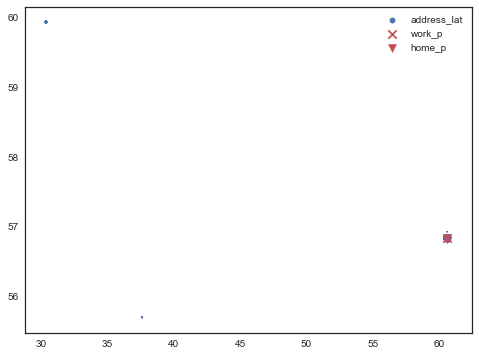

In [498]:
idn = 'ff4e78a42acf6bbb27d1678dc0f0e5a1'

coords = consolidated[consolidated.customer_id==idn][['address_lat','address_lon', 
                                                      'w1', 'h1', 'work_dist', 'home_dist']].copy()

latlon_pred = np.array(sub38[sub38._ID_== idn])
latlon_pred = latlon_pred[:,1:5]

y, x = coords.address_lat, coords.address_lon
df = pd.DataFrame(dict(x=x, y=y))

circle3 = plt.Circle((latlon_pred[0,1], latlon_pred[0,0]), 0.02, fill=False, color='r', ls='--');
circle4 = plt.Circle((latlon_pred[0,3], latlon_pred[0,2]), 0.02, fill=False, color='r', ls='--');

# Plot
fig, ax = plt.subplots(figsize=(8, 6))

ax.scatter(x, y, s=coords.w1*100, marker='o')

plt.scatter(latlon_pred[0,1], latlon_pred[0,0], s=70, marker='x', color='r', label='work_p');
plt.scatter(latlon_pred[0,3], latlon_pred[0,2], s=70, marker='v', color='r', label='home_p');    

ax.legend()

ax.add_artist(circle3)
ax.add_artist(circle4)
#plt.ylim(x.mean()-0.01,x.mean()+0.01)
#plt.xlim(y.mean()-0.01,y.mean()+0.01)

plt.show()

In [499]:
#idn = '3e5d772b1a8537d06d7ab760e153fafc'

m = folium.Map([55., 37.], tiles='stamentoner', zoom_start=6)

HeatMap(consolidated[consolidated.customer_id == idn]
        [['address_lat', 'address_lon']].values.tolist()).add_to(m)

folium.Marker([sub40[sub40._ID_ == idn]['_WORK_LAT_'].mean(), sub40[sub40._ID_ == idn]['_WORK_LON_'].mean()], 
              popup='work sub40', icon=folium.Icon(color='green')).add_to(m)
folium.Marker([sub40[sub40._ID_ == idn]['_HOME_LAT_'].mean(), sub40[sub40._ID_ == idn]['_HOME_LON_'].mean()], 
              popup='home sub40', icon=folium.Icon(color='red')).add_to(m)

folium.Marker([sub38[sub38._ID_ == idn]['_WORK_LAT_'].mean(), sub38[sub38._ID_ == idn]['_WORK_LON_'].mean()], 
              popup='work sub38', icon=folium.Icon(color='green')).add_to(m)
folium.Marker([sub38[sub38._ID_ == idn]['_HOME_LAT_'].mean(), sub38[sub38._ID_ == idn]['_HOME_LON_'].mean()], 
              popup='home sub38', icon=folium.Icon(color='red')).add_to(m)


m

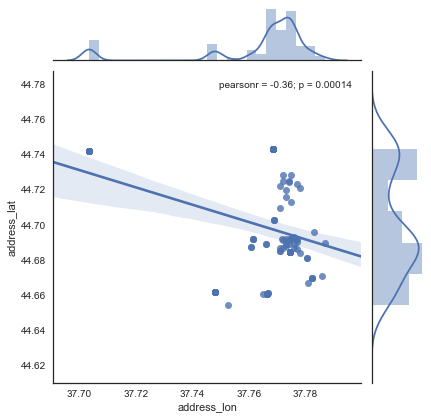

In [47]:
sns.jointplot(x='address_lon', y='address_lat', 
              data=consolidated[consolidated.customer_id == idn], kind='reg');

In [8]:
"""вычисляем топ по каждому ID"""
def top(df, n=3, column='y_pred'):
    return df.sort_values(by=column)[-n:]

"""вычислям взвешенное среднее значение"""
def weighted_average(df,data_col,weight_col,by_col):
    df['_data_times_weight'] = df[data_col]*df[weight_col]
    df['_weight_where_notnull'] = df[weight_col]*pd.notnull(df[data_col])
    g = df.groupby(by_col)
    result = g['_data_times_weight'].sum() / g['_weight_where_notnull'].sum()
    del df['_data_times_weight'], df['_weight_where_notnull']
    return result

In [140]:
#consolidated['h11'] = consolidated[['h1', 'home_prob']].mean(axis=1)

In [12]:
consolidated['h_dist_prob'] = (2 / consolidated['home_dist'])  + consolidated['h1']
consolidated['w_dist_prob'] = (2 / consolidated['work_dist'])  + consolidated['w1']

In [65]:
consolidated['h_dist_prob'] = (1 / consolidated['home_dist'])  * consolidated['h1']
consolidated['w_dist_prob'] = (1 / consolidated['work_dist'])  * consolidated['w1']

In [120]:
home_lat_answer = pd.DataFrame(weighted_average(un_gps_only_nearest_points, data_col='address_lat_x', 
                                                weight_col='mean', by_col='customer_id')).reset_index()
home_lon_answer = pd.DataFrame(weighted_average(un_gps_only_nearest_points, data_col='address_lon_x', 
                                                weight_col='mean', by_col='customer_id')).reset_index()
home_answer = pd.merge(home_lat_answer, home_lon_answer, on='customer_id', how='left')

In [121]:
un_gps_only = consolidated.groupby(['customer_id', 'gps']).agg({'w1': [np.size, np.median]}).reset_index()
un_gps_only.columns = un_gps_only.columns.droplevel(1)
un_gps_only.columns = ['customer_id', 'gps', 'count', 'mean']

In [122]:
un_gps_only = un_gps_only.groupby('customer_id').apply(top, n=7, column='mean')
un_gps_only.reset_index(drop=True, inplace=True)
un_gps_only['address_lat'] = un_gps_only['gps'].map(lambda x: str(x).split(',')[0]).apply(float)
un_gps_only['address_lon'] = un_gps_only['gps'].map(lambda x: str(x).split(',')[1]).apply(float)

In [ ]:
un_gps_only['max_prob'] = un_gps_only.groupby(['customer_id'])['mean'].transform(max)
max_prob_key = pd.DataFrame(un_gps_only.groupby(['customer_id'])['mean'].max()).reset_index()
max_prob_key = pd.merge(max_prob_key, un_gps_only[['customer_id', 'mean', 'address_lat', 'address_lon']], 
         on=['customer_id', 'mean'], how='left')
un_gps_only = pd.merge(un_gps_only, max_prob_key[['customer_id', 'address_lat', 'address_lon']], on='customer_id', how='left')

In [75]:
proximity_radius = 0.04
un_gps_only['is_close'] = (un_gps_only['address_lat_x'].between(un_gps_only['address_lat_y'] - proximity_radius, 
                                      un_gps_only['address_lat_y'] + proximity_radius, inclusive=True) &
 un_gps_only['address_lon_x'].between(un_gps_only['address_lon_y'] - proximity_radius, 
                                      un_gps_only['address_lon_y'] + proximity_radius, inclusive=True)).astype(int)

un_gps_only['is_close'].sum() / len(un_gps_only['is_close'])
un_gps_only_nearest_points = un_gps_only[un_gps_only.is_close == 1]
print(len(un_gps_only_nearest_points) / len(un_gps_only))

0.8910405266239929


In [77]:
submission = pd.merge(work_answer, home_answer, on='customer_id', how='left')

In [78]:
submission.columns = ['_ID_', '_WORK_LAT_', '_WORK_LON_', '_HOME_LAT_', '_HOME_LON_']
submission.index = submission._ID_
submission.drop("_ID_", axis=1, inplace=True)

In [79]:
submission.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9997 entries, 00021683ccb416637fe9a4cd35e4606e to ffebf4ea02c72183128d966721976ec9
Data columns (total 4 columns):
_WORK_LAT_    9997 non-null float64
_WORK_LON_    9997 non-null float64
_HOME_LAT_    9997 non-null float64
_HOME_LON_    9997 non-null float64
dtypes: float64(4)
memory usage: 390.5+ KB


In [80]:
submission.to_csv(r'...\subs\sub44.csv')

In [88]:
"""устанавливаем порог"""
low_prob_level_id = list(consolidated[(consolidated.w1 >= 0.2) & (consolidated.h1 >= 0.2)]['customer_id'].unique())
consolidated[(consolidated.w1 >= 0.2) & (consolidated.h1 >= 0.2)]['customer_id'].nunique()

4919

In [89]:
"""берем только те ID, в которых есть больше 2 кластеров (не считая -1 кластер)"""
with_two_or_more_clusters = consolidated[(consolidated.clusters >= 0)].groupby('customer_id')['clusters'].nunique().reset_index()
with_two_or_more_clusters = list(with_two_or_more_clusters[with_two_or_more_clusters.clusters >= 2]['customer_id'])

"""выбираем ID, которые следует проверить"""
id_to_change = list(set(list(with_two_or_more_clusters)) - 
                    set(low_prob_level_id))

df_to_choose_clusters = consolidated[consolidated.customer_id.isin(id_to_change)].groupby(
    ['customer_id', 'clusters'])[['w1','h1']].median().reset_index()

df_to_choose_clusters = pd.concat([df_to_choose_clusters, 
                                   df_to_choose_clusters.groupby('customer_id')[['w1', 'h1']].transform(max)], axis=1)
df_to_choose_clusters.columns = ['customer_id', 'clusters', 'w1', 'h1', 'w1_max', 'h1_max']

"добавляем 2, чтобы убрать 0"
df_to_choose_clusters['clusters'] = df_to_choose_clusters['clusters'] + 2

"""выбираем лидеров по ID: work/home; для них закрепляем опредленный кластер"""
df_to_choose_clusters['wm'] = (df_to_choose_clusters['w1'] == df_to_choose_clusters['w1_max']).astype(int)
df_to_choose_clusters['hm'] = (df_to_choose_clusters['h1'] == df_to_choose_clusters['h1_max']).astype(int)
df_to_choose_clusters['wh'] = (df_to_choose_clusters['w1_max'] > df_to_choose_clusters['h1_max']).astype(int)
df_to_choose_clusters['hw'] = (df_to_choose_clusters['w1_max'] < df_to_choose_clusters['h1_max']).astype(int)

df_to_choose_clusters['w_cl'] = df_to_choose_clusters['wh'] * df_to_choose_clusters['wm'] * df_to_choose_clusters['clusters']
df_to_choose_clusters['h_cl'] = df_to_choose_clusters['hw'] * df_to_choose_clusters['hm'] * df_to_choose_clusters['clusters']

"""группируем по ID и возвращаем реальные значения кластеров"""
df_to_choose_clusters = df_to_choose_clusters.groupby('customer_id')[['w_cl', 'h_cl']].sum().reset_index()
df_to_choose_clusters['w_cl'] = df_to_choose_clusters['w_cl'] - 2
df_to_choose_clusters['h_cl'] = df_to_choose_clusters['h_cl'] - 2
df_to_choose_clusters = df_to_choose_clusters.replace(-2,np.nan)

In [90]:
"""WORK mask
    mask - ID+кластеры, которые должен изменить"""

mask1 = df_to_choose_clusters[df_to_choose_clusters.h_cl.isnull()==0][
    ['customer_id', 'h_cl']].rename(columns={'h_cl':'clusters'}).reset_index(drop=True)
mask1.clusters = mask1.clusters.astype(int)
mask1['marker'] = True

"""создаем DF """
df1 = pd.merge(consolidated, mask1, on=['customer_id','clusters'], how='left')
df1 = df1[df1.marker.isnull()].drop('marker', axis=1)
df1 = df1[df1.customer_id.isin(mask1.customer_id)]

In [91]:
"""HOME mask
    mask - ID+кластеры, которые должен изменить"""

mask2 = df_to_choose_clusters[df_to_choose_clusters.w_cl.isnull()==0][
    ['customer_id', 'w_cl']].rename(columns={'w_cl':'clusters'}).reset_index(drop=True)
mask2.clusters = mask2.clusters.astype(int)
mask2['marker'] = True

"""создаем DF """
df2 = pd.merge(consolidated, mask2, on=['customer_id','clusters'], how='left')
df2 = df2[df2.marker.isnull()].drop('marker', axis=1)
df2 = df2[df2.customer_id.isin(mask2.customer_id)]

In [92]:
df1.customer_id.nunique(), df2.customer_id.nunique()

(2632, 1858)

In [93]:
df1[df1.clusters>= 0].customer_id.nunique(), df2[df2.clusters>= 0].customer_id.nunique(),

(2632, 1858)

In [94]:
df1 = df1[df1.clusters>= 0]
df2 = df2[df2.clusters>= 0]

In [95]:
un_gps_only = df1.groupby(['customer_id', 'gps']).agg({'w_dist_prob': [np.size, np.median]}).reset_index()
un_gps_only.columns = un_gps_only.columns.droplevel(1)
un_gps_only.columns = ['customer_id', 'gps', 'count', 'mean']

In [96]:
un_gps_only = un_gps_only.groupby('customer_id').apply(top, n=5, column='mean')
un_gps_only.reset_index(drop=True, inplace=True)
un_gps_only['address_lat'] = un_gps_only['gps'].map(lambda x: str(x).split(',')[0]).apply(float)
un_gps_only['address_lon'] = un_gps_only['gps'].map(lambda x: str(x).split(',')[1]).apply(float)

In [97]:
un_gps_only['max_prob'] = un_gps_only.groupby(['customer_id'])['mean'].transform(max)
max_prob_key = pd.DataFrame(un_gps_only.groupby(['customer_id'])['mean'].max()).reset_index()
max_prob_key = pd.merge(max_prob_key, un_gps_only[['customer_id', 'mean', 'address_lat', 'address_lon']], 
         on=['customer_id', 'mean'], how='left')
un_gps_only = pd.merge(un_gps_only, max_prob_key[['customer_id', 'address_lat', 'address_lon']], on='customer_id', how='left')

In [98]:
proximity_radius = 0.04
un_gps_only['is_close'] = (un_gps_only['address_lat_x'].between(un_gps_only['address_lat_y'] - proximity_radius, 
                                      un_gps_only['address_lat_y'] + proximity_radius, inclusive=True) &
 un_gps_only['address_lon_x'].between(un_gps_only['address_lon_y'] - proximity_radius, 
                                      un_gps_only['address_lon_y'] + proximity_radius, inclusive=True)).astype(int)

un_gps_only['is_close'].sum() / len(un_gps_only['is_close'])
un_gps_only_nearest_points = un_gps_only[un_gps_only.is_close == 1]
print(len(un_gps_only_nearest_points) / len(un_gps_only))

0.8210637887839661


In [99]:
work_lat_answer_adj = pd.DataFrame(weighted_average(un_gps_only_nearest_points, data_col='address_lat_x', 
                                                weight_col='mean', by_col='customer_id')).reset_index()
work_lon_answer_adj = pd.DataFrame(weighted_average(un_gps_only_nearest_points, data_col='address_lon_x', 
                                                weight_col='mean', by_col='customer_id')).reset_index()
work_answer_adj = pd.merge(work_lat_answer_adj, work_lon_answer_adj, on='customer_id', how='left')

In [100]:
len(work_answer_adj)

2632

In [101]:
un_gps_only = df2.groupby(['customer_id', 'gps']).agg({'h_dist_prob': [np.size, np.median]}).reset_index()
un_gps_only.columns = un_gps_only.columns.droplevel(1)
un_gps_only.columns = ['customer_id', 'gps', 'count', 'mean']

In [102]:
un_gps_only = un_gps_only.groupby('customer_id').apply(top, n=5, column='mean')
un_gps_only.reset_index(drop=True, inplace=True)
un_gps_only['address_lat'] = un_gps_only['gps'].map(lambda x: str(x).split(',')[0]).apply(float)
un_gps_only['address_lon'] = un_gps_only['gps'].map(lambda x: str(x).split(',')[1]).apply(float)

In [103]:
un_gps_only['max_prob'] = un_gps_only.groupby(['customer_id'])['mean'].transform(max)
max_prob_key = pd.DataFrame(un_gps_only.groupby(['customer_id'])['mean'].max()).reset_index()
max_prob_key = pd.merge(max_prob_key, un_gps_only[['customer_id', 'mean', 'address_lat', 'address_lon']], 
         on=['customer_id', 'mean'], how='left')
un_gps_only = pd.merge(un_gps_only, max_prob_key[['customer_id', 'address_lat', 'address_lon']], on='customer_id', how='left')

In [104]:
proximity_radius = 0.04
un_gps_only['is_close'] = (un_gps_only['address_lat_x'].between(un_gps_only['address_lat_y'] - proximity_radius, 
                                      un_gps_only['address_lat_y'] + proximity_radius, inclusive=True) &
 un_gps_only['address_lon_x'].between(un_gps_only['address_lon_y'] - proximity_radius, 
                                      un_gps_only['address_lon_y'] + proximity_radius, inclusive=True)).astype(int)

un_gps_only['is_close'].sum() / len(un_gps_only['is_close'])
un_gps_only_nearest_points = un_gps_only[un_gps_only.is_close == 1]
print(len(un_gps_only_nearest_points) / len(un_gps_only))

0.8809865900383141


In [105]:
home_lat_answer_adj = pd.DataFrame(weighted_average(un_gps_only_nearest_points, data_col='address_lat_x', 
                                                weight_col='mean', by_col='customer_id')).reset_index()
home_lon_answer_adj = pd.DataFrame(weighted_average(un_gps_only_nearest_points, data_col='address_lon_x', 
                                                weight_col='mean', by_col='customer_id')).reset_index()
home_answer_adj = pd.merge(home_lat_answer_adj, home_lon_answer_adj, on='customer_id', how='left')

In [106]:
len(home_answer_adj)

1858

In [107]:
"""что делаем с разными городами ???"""

w = work_answer.merge(work_answer_adj, on='customer_id', how='left')
h = home_answer.merge(home_answer_adj, on='customer_id', how='left')

In [108]:
w['0_x_y'] = w['0_x_y'].fillna(w['0_x_x'])
w['0_y_y'] = w['0_y_y'].fillna(w['0_y_x'])
w.drop(w.columns[1:3], axis=1, inplace=True)

h['0_x_y'] = h['0_x_y'].fillna(h['0_x_x'])
h['0_y_y'] = h['0_y_y'].fillna(h['0_y_x'])
h.drop(h.columns[1:3], axis=1, inplace=True)

In [109]:
submission = pd.merge(w, h, on='customer_id', how='left')

In [110]:
submission.columns = ['_ID_', '_WORK_LAT_', '_WORK_LON_', '_HOME_LAT_', '_HOME_LON_']
submission.index = submission._ID_
submission.drop("_ID_", axis=1, inplace=True)

In [112]:
submission.head()

,_WORK_LAT_,_WORK_LON_,_HOME_LAT_,_HOME_LON_
_ID_,,,,
00021683ccb416637fe9a4cd35e4606e,55.033640,82.973705,55.039727,82.980388
0002d0f8a642272b41c292c12ab6e602,53.199818,50.173374,44.031992,42.836928
0004d182d9fede3ba2534b2d5e5ad27e,43.587112,39.725958,43.594270,39.725548
0008c2445518c9392cb356c5c3db3392,51.530492,46.034490,51.531920,46.032165
000b373cc4969c0be8e0933c08da67e1,56.319286,43.925818,56.236605,43.459858


In [113]:
(((sub38['_WORK_LON_'] - submission['_WORK_LON_'].values) > 2) | 
 ((sub38['_WORK_LAT_'] - submission['_WORK_LAT_'].values) > 2) | 
 ((sub38['_HOME_LON_'] - submission['_HOME_LON_'].values) > 2) | 
((sub38['_HOME_LAT_'] - submission['_HOME_LAT_'].values) > 2) ).sum()

162

In [114]:
submission.to_csv(r'...\subs\sub45.csv')

In [534]:
submission.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9997 entries, 00021683ccb416637fe9a4cd35e4606e to ffebf4ea02c72183128d966721976ec9
Data columns (total 4 columns):
_WORK_LAT_    9997 non-null float64
_WORK_LON_    9997 non-null float64
_HOME_LAT_    9997 non-null float64
_HOME_LON_    9997 non-null float64
dtypes: float64(4)
memory usage: 390.5+ KB


In [ ]:
"""
0002d0f8a642272b41c292c12ab6e602
ff4e78a42acf6bbb27d1678dc0f0e5a1
"""

In [115]:
(submission['_WORK_LAT_'].between(submission['_HOME_LAT_'] - RADIUS, 
                                      submission['_HOME_LAT_'] + RADIUS, inclusive=True) &
 (submission['_WORK_LON_'].between(submission['_HOME_LON_'] - RADIUS, 
                                      submission['_HOME_LON_'] + RADIUS, inclusive=True))).astype(int).sum() / 9997

0.42202660798239472